In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import os
from IPython import display
from sklearn import tree

In [6]:
cd D:/FTI Consulting

D:\FTI Consulting


In [7]:
# read as pandas dataframe object, parse date columns while reading
transact_raw_df = pd.read_json(open("transactions.txt"), lines=True, dtype=True, convert_dates=['accountOpenDate', 'currentExpDate', 'dateOfLastAddressChange', 'transactionDateTime'])
transact_raw_df.head()

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,...,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionAmount,transactionDateTime,transactionType
0,737265056,2015-03-14,US,5000.0,414,1803,False,5000,0.0,2023-06-01,...,Uber,,,01,02,,,98.55,2016-08-13 14:27:32,PURCHASE
1,737265056,2015-03-14,US,5000.0,486,767,True,5000,0.0,2024-02-01,...,AMC #191138,,,01,09,,,74.51,2016-10-11 05:05:54,PURCHASE
2,737265056,2015-03-14,US,5000.0,486,767,False,5000,0.0,2025-08-01,...,Play Store,,,01,09,,,7.47,2016-11-08 09:18:39,PURCHASE
3,737265056,2015-03-14,US,5000.0,486,767,False,5000,0.0,2025-08-01,...,Play Store,,,01,09,,,7.47,2016-12-10 02:14:50,PURCHASE
4,830329091,2015-08-06,US,5000.0,885,3143,True,5000,0.0,2029-10-01,...,Tim Hortons #947751,,,01,02,,,71.18,2016-03-24 21:04:46,PURCHASE


# Data Analysis

In [8]:
# Create a copy of the raw data for manipulation
transact_df = transact_raw_df.copy()

In [9]:
# Replace whitespace in data with NaN values
transact_df = transact_df.replace('', np.nan, regex=True)

In [10]:
print("The dataset has {} records with {} fields.".format(*transact_df.shape))

The dataset has 786363 records with 29 fields.


In [11]:
# Columns in the dataset
transact_df.columns

Index(['accountNumber', 'accountOpenDate', 'acqCountry', 'availableMoney',
       'cardCVV', 'cardLast4Digits', 'cardPresent', 'creditLimit',
       'currentBalance', 'currentExpDate', 'customerId',
       'dateOfLastAddressChange', 'echoBuffer', 'enteredCVV',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCity', 'merchantCountryCode', 'merchantName', 'merchantState',
       'merchantZip', 'posConditionCode', 'posEntryMode', 'posOnPremises',
       'recurringAuthInd', 'transactionAmount', 'transactionDateTime',
       'transactionType'],
      dtype='object')

In [12]:
# Index, Datatype and Memory information
transact_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
accountNumber               786363 non-null int64
accountOpenDate             786363 non-null datetime64[ns]
acqCountry                  781801 non-null object
availableMoney              786363 non-null float64
cardCVV                     786363 non-null int64
cardLast4Digits             786363 non-null int64
cardPresent                 786363 non-null bool
creditLimit                 786363 non-null int64
currentBalance              786363 non-null float64
currentExpDate              786363 non-null datetime64[ns]
customerId                  786363 non-null int64
dateOfLastAddressChange     786363 non-null datetime64[ns]
echoBuffer                  0 non-null float64
enteredCVV                  786363 non-null int64
expirationDateKeyInMatch    786363 non-null bool
isFraud                     786363 non-null bool
merchantCategoryCode        786363 non-null object
merchantCity

In [13]:
#Column wise count of null values
transact_df.isnull().sum()

accountNumber                    0
accountOpenDate                  0
acqCountry                    4562
availableMoney                   0
cardCVV                          0
cardLast4Digits                  0
cardPresent                      0
creditLimit                      0
currentBalance                   0
currentExpDate                   0
customerId                       0
dateOfLastAddressChange          0
echoBuffer                  786363
enteredCVV                       0
expirationDateKeyInMatch         0
isFraud                          0
merchantCategoryCode             0
merchantCity                786363
merchantCountryCode            724
merchantName                     0
merchantState               786363
merchantZip                 786363
posConditionCode               409
posEntryMode                  4054
posOnPremises               786363
recurringAuthInd            786363
transactionAmount                0
transactionDateTime              0
transactionType     

In [14]:
# drop null columns
null_cols = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']
transact_df.drop(null_cols, axis=1, inplace=True)

In [15]:
# Remove duplicate entries 
acct_df = transact_df[['accountNumber', 'customerId']]
acct_df = acct_df.drop_duplicates()

In [16]:
acct_cnt = acct_df.groupby(['accountNumber'])['customerId'].count()
acct_cnt.value_counts()

1    5000
Name: customerId, dtype: int64

There are 5000 unique account numbers/customers in the data. The fields accountNumber and customerId have one-to-one mapping, hence we can use one of them and drop the other. We will drop the customerID column.

In [17]:
transact_df.drop('customerId', axis=1, inplace=True)

### Levels of Data 

In [18]:
print("The dateset contains transaction level information from {} to {}".format(transact_df['transactionDateTime'].dt.date.min(), transact_df['transactionDateTime'].dt.date.max()))

The dateset contains transaction level information from 2016-01-01 to 2016-12-30


In [19]:
transact_df['transactionDate'] = transact_df['transactionDateTime'].dt.date
transact_df['transactionTime'] = transact_df['transactionDateTime'].dt.time
transact_df['transactionHour'] = transact_df['transactionDateTime'].dt.hour

Analysis of transactions with date might reveal interesting spending patterns.

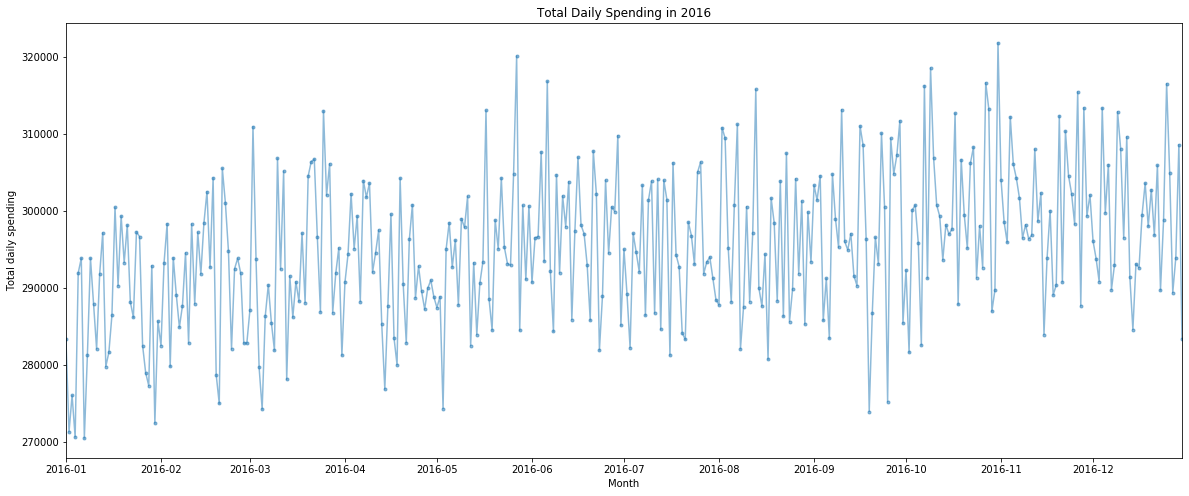

In [20]:
# Creating a data frame of transcation dates and amounts 
date_df = transact_df[['transactionDate', 'transactionAmount']]
date_df = date_df.sort_values(by='transactionDate')

# summing transaction amount at a daily level
date_df = date_df.groupby('transactionDate')['transactionAmount'].sum().reset_index()
date_df = date_df.set_index('transactionDate')

# plotting total daily spending
plt.figure(figsize=(20,8))
date_df['transactionAmount'].plot(alpha=0.5, marker='.', linestyle='-')
plt.title('Total Daily Spending in 2016')
plt.ylabel('Total daily spending')
plt.xlabel('Month')
plt.show()

The transaction data shows clear seasonality with average daily transactions increasing around holidays. We can observes spikes in spending amounts in mid-February (Valentine's day), end of March (Easter), mid-May (Mother's day), beginning of June (Father's day), end of October (Halloween), end of November (Thanksgiving) and end of Decemebr (Christmas).

### Unique number of credit cards

In [21]:
print("There are {} unique credit cards available in the dataset".format(len(transact_df['cardLast4Digits'].unique())))

There are 5245 unique credit cards available in the dataset


The number of unique credit cards is higher than the number of unique customers in the data. This implies that some customers have more than one credit card. We can use this information to create a new variable to use in our predictive model

### Analysis of continuous variables

There are four continuous variables for which we can calculate some summary statistics. We can also plot histograms of these variables to understand their statistical distribution.

In [22]:
continuous =  ['availableMoney', 'creditLimit', 'currentBalance', 'transactionAmount']

for col in continuous:
    print("Summary statistics for '{}' variable:".format(col), "\n")
    print(transact_df[col].describe(), "\n")

Summary statistics for 'availableMoney' variable: 

count    786363.000000
mean       6250.725369
std        8880.783989
min       -1005.630000
25%        1077.420000
50%        3184.860000
75%        7500.000000
max       50000.000000
Name: availableMoney, dtype: float64 

Summary statistics for 'creditLimit' variable: 

count    786363.000000
mean      10759.464459
std       11636.174890
min         250.000000
25%        5000.000000
50%        7500.000000
75%       15000.000000
max       50000.000000
Name: creditLimit, dtype: float64 

Summary statistics for 'currentBalance' variable: 

count    786363.000000
mean       4508.739089
std        6457.442068
min           0.000000
25%         689.910000
50%        2451.760000
75%        5291.095000
max       47498.810000
Name: currentBalance, dtype: float64 

Summary statistics for 'transactionAmount' variable: 

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%        

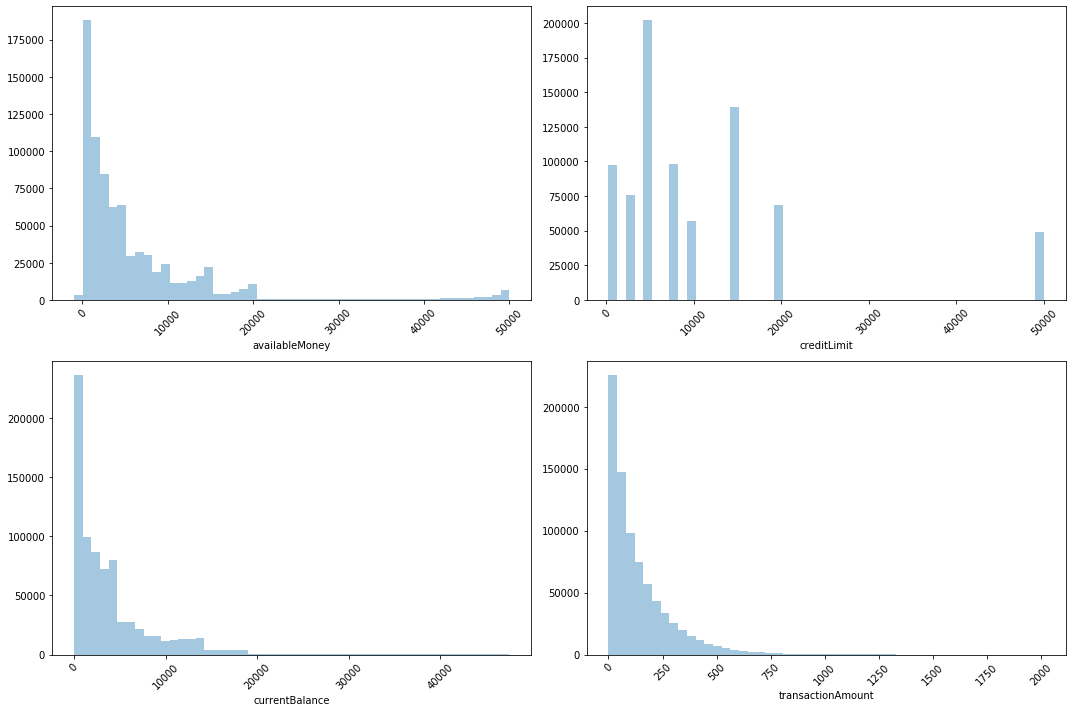

In [23]:
# Plotting histograms of continuous variables
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.distplot(transact_df['availableMoney'], kde=False)
plt.xticks(rotation=45)

plt.subplot(2,2,2)
sns.distplot(transact_df['creditLimit'], kde=False)
plt.xticks(rotation=45)

plt.subplot(2,2,3)
sns.distplot(transact_df['currentBalance'], kde=False)
plt.xticks(rotation=45)

plt.subplot(2,2,4)
sns.distplot(transact_df['transactionAmount'], kde=False)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Observations
The 4 continuous variables are highly skewed to the right with long tails and do not seem to follow a normal distribution.

- The variables 'availableMoney', 'currentBalance' and 'transactionAmount' seem to follow an exponential distribution
- The variable 'creditLimit' is multimodal with distinct peaks

### Analyzing categorical variables¶

There are 10 categorical variables in the data for which we can calculate the value counts and plot the frequency distribution.

In [24]:
# Utility function to calculate the distribution and visualize a categorical variable
def plot_cat(df, col):
    col_dist = df[col].value_counts()
    
    print("Value counts of '{}' variable:".format(col), '\n')
    print(col_dist, '\n')

    plt.figure(figsize=(25,6))
    col_dist.plot(kind='barh')
    plt.title("Distribution of '{}' variable".format(col))
    plt.xlabel("Frequency")
    plt.ylabel("{}".format(col))
    plt.xticks(rotation=45)
    plt.show()

Value counts of 'isFraud' variable: 

False    773946
True      12417
Name: isFraud, dtype: int64 



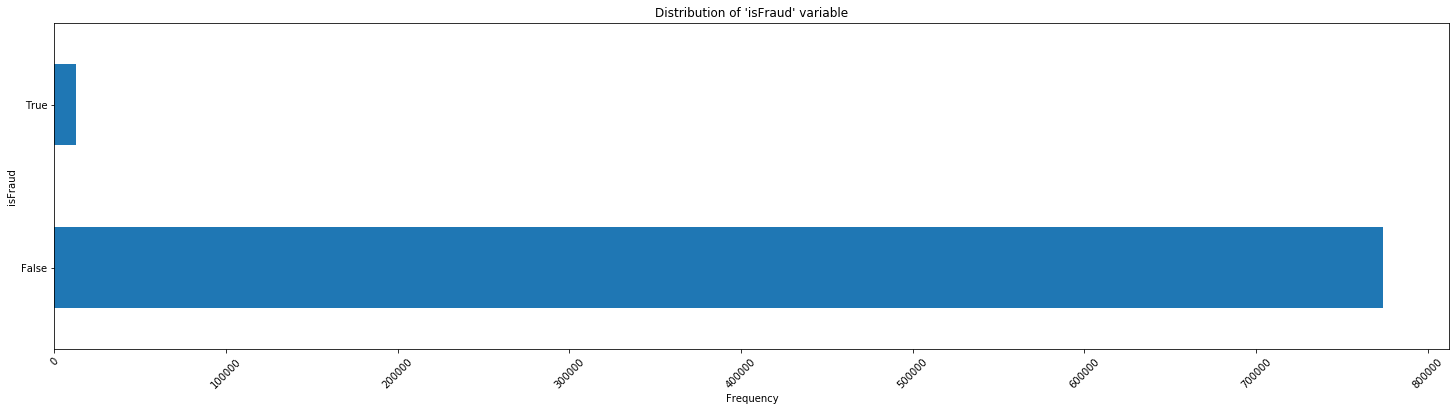

In [25]:
plot_cat(transact_df, 'isFraud')

Highly imbalanced data with event rate of 1.5%

Value counts of 'merchantCategoryCode' variable: 

online_retail           202156
fastfood                112138
entertainment            80098
food                     75490
online_gifts             66238
rideshare                51136
hotels                   34097
fuel                     23910
subscriptions            22901
auto                     21651
health                   19092
personal care            18964
airline                  15412
mobileapps               14990
online_subscriptions     11067
furniture                 7432
food_delivery             6000
gym                       2209
cable/phone               1382
Name: merchantCategoryCode, dtype: int64 



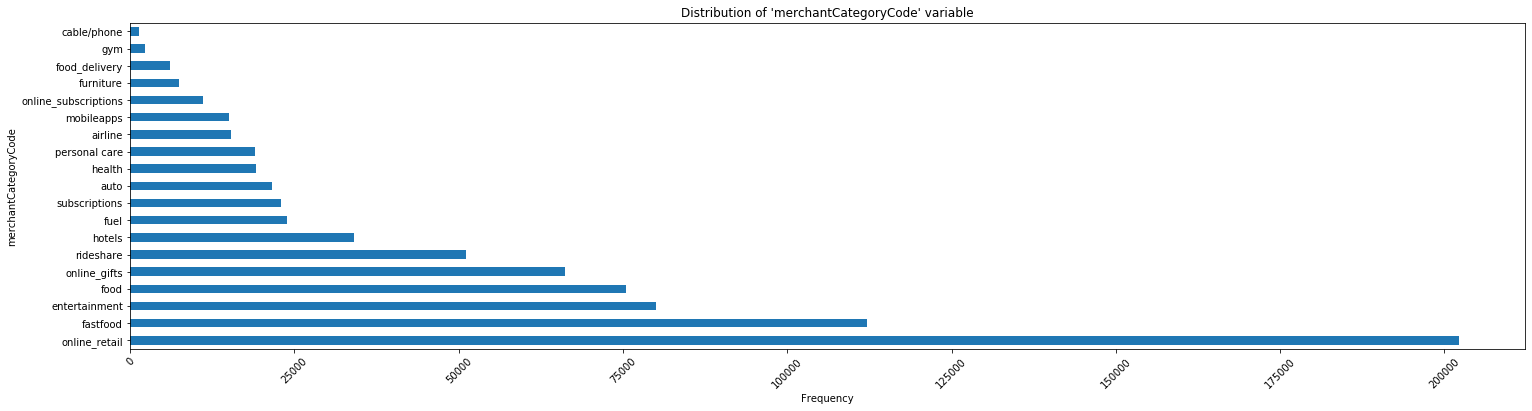

In [26]:
plot_cat(transact_df, 'merchantCategoryCode')

In [27]:
transact_df['merchantCategoryCode'].value_counts().reset_index(drop=True)

0     202156
1     112138
2      80098
3      75490
4      66238
5      51136
6      34097
7      23910
8      22901
9      21651
10     19092
11     18964
12     15412
13     14990
14     11067
15      7432
16      6000
17      2209
18      1382
Name: merchantCategoryCode, dtype: int64

The largest number of transactions correspond to online retail merchants followed by fastfood and entertainment.

Value counts of 'transactionType' variable: 

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64 



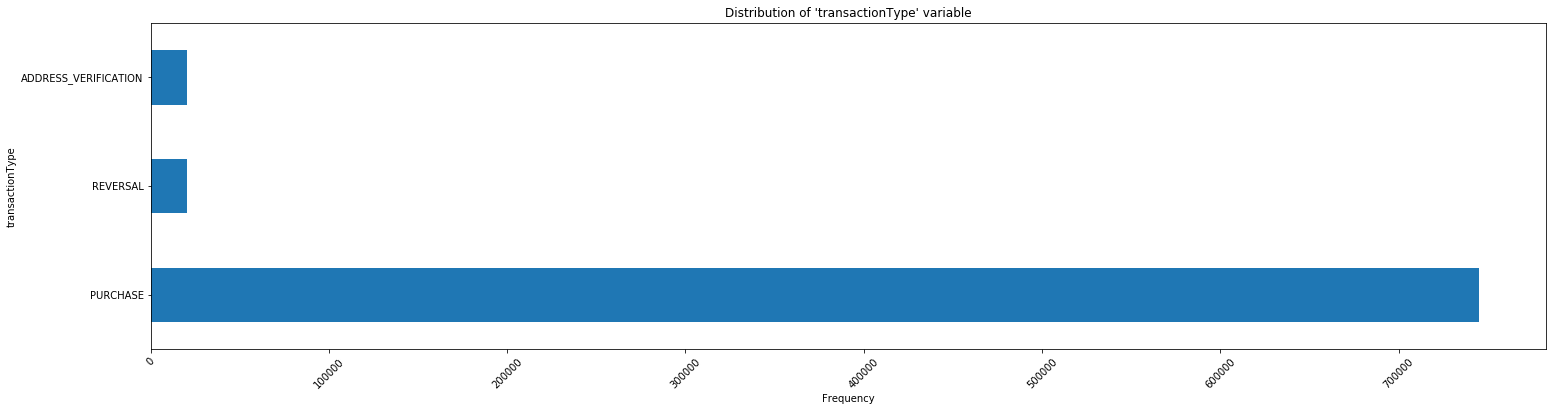

In [28]:
plot_cat(transact_df, 'transactionType')

The majority of transactions are of type Purchase.

### Merchants
Since the dataset is at a transaction level, the variable 'merchantName' would have numerous unique values and visualizing it would be difficult. Instead, we can obtain a count of the unique merchants available in the dataset.

In [29]:
print("There are {} unique merchants available in the dataset.".format(len(transact_df['merchantName'].unique())))

There are 2490 unique merchants available in the dataset.


### Date variables
We can use the 'accountOpenDate' variable to calculate the number of accounts opened per year.

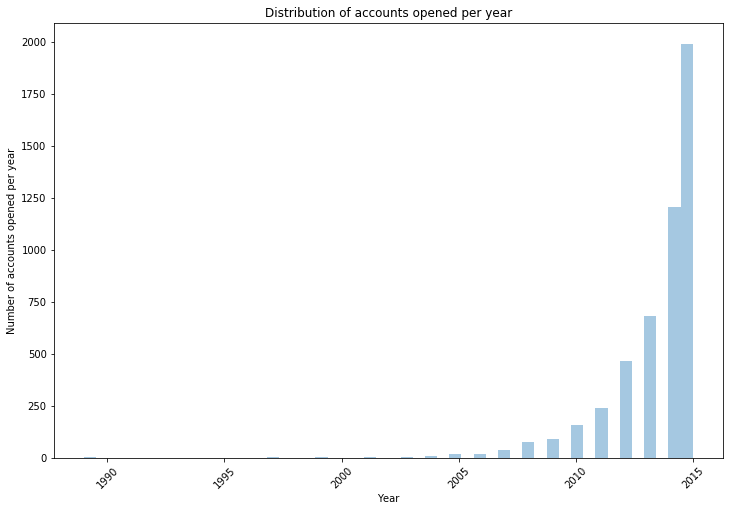

In [30]:
transact_df['accountOpenYear'] = transact_df['accountOpenDate'].dt.year

# Roll up account numbers by year of opening
open_df = transact_df[['accountNumber', 'accountOpenYear']]
open_df = open_df.drop_duplicates()
open_df = open_df.sort_values(by=['accountOpenYear'], ascending=True)

#Plot the distribution of accounts opened per year
plt.figure(figsize=(12,8))
sns.distplot(open_df['accountOpenYear'], kde=False)
plt.title('Distribution of accounts opened per year')
plt.ylabel('Number of accounts opened per year')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.show()

The number of originations (accounts opened per year) has clearly increased exponentially post 2010.

### CVV
There are two CVV variables 'cardCVV' and 'enteredCVV' which on their own do not provide any interesting information. We can see if there are cases where there is a mismatch between the CVV fields. We will later use this variable as a feature in our predictive model

In [31]:
# Create CVV mismatch flag
transact_df.loc[transact_df['cardCVV'] == transact_df['enteredCVV'], 'CVV_mismatch'] = 0
transact_df.loc[transact_df['cardCVV'] != transact_df['enteredCVV'], 'CVV_mismatch'] = 1

In [32]:
transact_df['CVV_mismatch'].value_counts()

0.0    779348
1.0      7015
Name: CVV_mismatch, dtype: int64

In [33]:
CVV_amt = transact_df.groupby(['CVV_mismatch'])[['transactionAmount']].sum().reset_index()
print("Total transaction amount for transactions with CVV mismatch is $ {:,.2f}".format(CVV_amt.loc[CVV_amt['CVV_mismatch']==1, 'transactionAmount'][1]))

Total transaction amount for transactions with CVV mismatch is $ 953,301.86


This is a quite an unexpected amount. However, there are merchants who process transactions even when there is a CVV mismatch (using information such as billing adress to authorize the transaction). So we need further analyis/data to draw any strong conclusions from this finding.

To identify the duplicate transactions, I have created a subset of the data with the records rolled up at a level combining the fields accountNumber, merchantName, merchantCountryCode and transactionAmount. The idea is to capture all repeated transactions for an account number which has the same transaction amount for the same merchant in the same country.

In [34]:
# Create a subset of the data with the required columns
cols = ['accountNumber', 'merchantName', 'merchantCountryCode', 'transactionAmount', 'transactionType', 'transactionDateTime', 'transactionDate', 'transactionTime', 'transactionHour']
subset_df = transact_df[cols]

# Sort
subset_df = subset_df.sort_values(['accountNumber', 'merchantName', 'merchantCountryCode', 'transactionAmount', 'transactionDateTime']).reset_index(drop=True)

# filter out duplicate transactions
duplicate_df = subset_df[subset_df.duplicated(['accountNumber', 'merchantName', 'merchantCountryCode', 'transactionAmount'], keep=False)]

In [35]:
# Identify reversed transactions
reversal = duplicate_df[duplicate_df['transactionType'] == 'REVERSAL']

Multi-swipe transactions happen in the case of PURCHASE transactions. Hence, we can extract the records corresponding to purchase transactions and look for duplicated records. The idea is to capture all repeated transactions for an account number which has the same transaction amount for the same merchant in the same country done on the same date during the same hour.



In [36]:
# Identify multi-swipe transactions
purchase_df = subset_df[subset_df['transactionType'] == 'PURCHASE']
dup_purchase_df = purchase_df[purchase_df.duplicated(['accountNumber', 'merchantName', 'merchantCountryCode', 'transactionAmount', 'transactionDate', 'transactionHour'])]

In [37]:
print('There are {} transactions corresponding to reversed transactions.'.format(reversal.shape[0]))

There are 18363 transactions corresponding to reversed transactions.


In [38]:
print('Total dollar amount from reversed transactions is $ {:,.2f}.'.format(round(reversal['transactionAmount'].sum(), 2)))

Total dollar amount from reversed transactions is $ 2,670,166.29.


In [39]:
print('There are {} transactions corresponding to multi-swipe transactions.'.format(dup_purchase_df.shape[0]))

There are 7249 transactions corresponding to multi-swipe transactions.


In [40]:
print('Total dollar amount from multi-swipe transactions is $ {:,.2f}.'.format(round(dup_purchase_df['transactionAmount'].sum(), 2)))

Total dollar amount from multi-swipe transactions is $ 1,075,506.80.


In [41]:
# Dollar value of reversed transactions at merchant level
reversal_merchant = reversal.groupby(['merchantName'])[['transactionAmount']].sum()
reversal_merchant.reset_index(level=0, inplace=True) #resetting index

# Sort in descending order of total transaction amount
reversal_merchant = reversal_merchant.sort_values(['transactionAmount'], ascending=False).reset_index(drop=True)

In [42]:
reversal_merchant.head(10)

,merchantName,transactionAmount
0,Uber,98243.39
1,Lyft,91791.89
2,gap.com,66192.22
3,alibaba.com,63691.11
4,ebay.com,63527.74
5,target.com,61770.49
6,apple.com,60825.16
7,staples.com,59231.67
8,walmart.com,57253.38
9,sears.com,57017.44


The highest dollar value of reversed transactions seem to come from rideshare services like Uber and Lyft (arising from ride cancellations) and e-commerce websites like gap.com. alibaba.com, ebay.com etc (arising from returned purchases).

In [43]:
# Dollar value of multi-swipe transactions at merchant level
multi_swipe_merchant = dup_purchase_df.groupby(['merchantName'])[['transactionAmount']].sum()
multi_swipe_merchant.reset_index(level=0, inplace=True) #resetting index

# Sort in descending order of total transaction amount
multi_swipe_merchant = multi_swipe_merchant.sort_values(['transactionAmount'], ascending=False).reset_index(drop=True)

In [44]:
multi_swipe_merchant.head(10)

,merchantName,transactionAmount
0,Uber,42395.11
1,Lyft,36597.92
2,alibaba.com,28842.24
3,sears.com,28624.67
4,oldnavy.com,27939.46
5,ebay.com,26438.16
6,gap.com,25919.68
7,apple.com,24970.37
8,staples.com,24715.63
9,target.com,24242.59


The trend is similar for multi swipe transactions as well. The highest dollar value for multiswipe transactions is contributed by rideshare services like Uber and Lyft (arising from booking multiple rides) and e-commerce websites like gap.com. alibaba.com, ebay.com etc. (arising usually from credit card preauthorization holds). The dollar amount is highest for these merchants due to the sheer volume of people utilizing their services.

# Model Building

### Step 0: Data Cleaning

Before modeling, we will drop the records with null values because certain modeling algorithms do not handle null values

In [45]:
transact_df.dropna(inplace=True)
transact_df.reset_index(drop=True, inplace=True)

In [46]:
transact_df['isFraud'] = transact_df['isFraud'].astype(int)

print(transact_df['isFraud'].value_counts(), '\n')
print(round(transact_df['isFraud'].value_counts(normalize=True)*100, 2))

0    764702
1     11966
Name: isFraud, dtype: int64 

0    98.46
1     1.54
Name: isFraud, dtype: float64


The data is highly imbalanced with only ~1.5% of our transactions being Fraud transactions and ~98.5% of transactions being NonFraud. Creating a predictive model on imbalanced data would be highly susceptible to overrfitting. Our model will 'assume' most transactions are not fraud which is undesirable. There are two approaches I have considered to address this issue:

Upsampling: I have chosen to upsample the data which is a technique that will process the data to have an approximate 50-50 ratio of the label classes by repeatedly sampling (with replacement) from the minority class.
Model Evaluation: Metrics like area under the ROC curve and F1 score which measure the classification power (ability to distinguish between classes correctly) of the classifier are prefered to metrics like accuracy since they are more robust to class imbalances.

### Step 2: Feature Engineering

The goal of feature engineering is to create new features by combining existing variables which might provide more information about the target variable.

In [47]:
# Value count of CVV mismatches
transact_df['CVV_mismatch'].value_counts()

0.0    769738
1.0      6930
Name: CVV_mismatch, dtype: int64

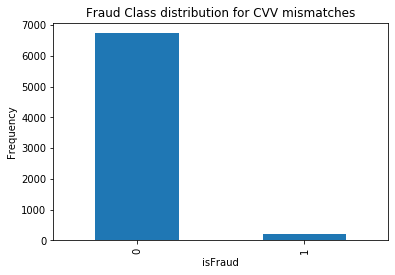

In [48]:
# Extract records with CVV mismatches
CVV_mismatch = transact_df[(transact_df['CVV_mismatch'] == 1)]

# Count of fraudulent transactions for CVV mismatches
isFraud_cvv_mismatch = CVV_mismatch['isFraud'].value_counts()

# Plot distribution of fraudulent transactions for CVV mismatches 
isFraud_cvv_mismatch.plot(kind = 'bar')
plt.title("Fraud Class distribution for CVV mismatches")
plt.xlabel("isFraud")
plt.ylabel("Frequency")
plt.show()

In [49]:
# Value count frauds of mismatch cvv
CVV_mismatch['isFraud'].value_counts()

0    6732
1     198
Name: isFraud, dtype: int64

Majority of the transactions with CVV mismatches are not fraudulent. The event rate increased by 0.5%.

Categorcal variable to flag if the country where the transaction was performed and the merchant country are the same.

In [50]:
transact_df.loc[transact_df['acqCountry'] == transact_df['merchantCountryCode'], 'Country_mismatch'] = 0
transact_df.loc[transact_df['acqCountry'] != transact_df['merchantCountryCode'], 'Country_mismatch'] = 1

In [51]:
transact_df['Country_mismatch'].value_counts()

0.0    776601
1.0        67
Name: Country_mismatch, dtype: int64

There are very few overseas transactions available in the data.

Numeric variable to calculate the utilization rate. Utilization rate is the ratio of the the credit utilized to the credit limit.

In [52]:
transact_df['utilization_rate'] = transact_df['currentBalance']/transact_df['creditLimit']

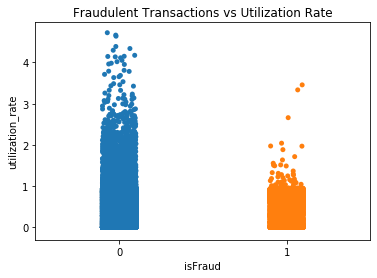

In [53]:
# Plotting the distribution of fraudulent transactions and utilization rate
sns.stripplot(x='isFraud', y='utilization_rate', data=transact_df)
plt.title('Fraudulent Transactions vs Utilization Rate')
plt.show()

In [54]:
# Check if a customer has mutiple credit cards
cards_df = transact_df[['accountNumber', 'cardLast4Digits']]
cards_df = cards_df.drop_duplicates()

# Count of credit cards at customer level
cards_df = cards_df.groupby(['accountNumber'])[['cardLast4Digits']].count()
cards_df.reset_index(level=0, inplace=True)

# rename column name
cards_df = cards_df.rename({'cardLast4Digits':'numCards'}, axis=1)
cards_df['numCards'].value_counts()

1    3104
2    1471
3     369
4      45
5       7
6       1
Name: numCards, dtype: int64

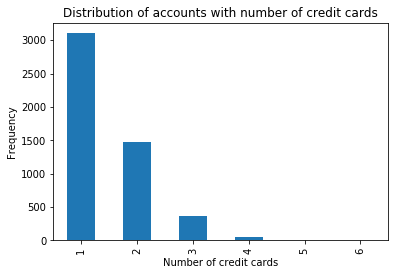

In [55]:
# Distribution of accounts with number of credit cards 
cards_df_number = cards_df['numCards'].value_counts()

# Plot distribution of accounts with number of credit cards  
cards_df_number.plot(kind = 'bar')
plt.title("Distribution of accounts with number of credit cards")
plt.xlabel("Number of credit cards")
plt.ylabel("Frequency")
plt.show()

In [56]:
transact_df = pd.merge(transact_df, cards_df, on='accountNumber', how='left')

About 40% customers own more than one credit cards.

In [57]:
# Num of fraud transactions at merchant level
num_frauds_merchant = transact_df.groupby(['merchantName'])[['isFraud']].sum()
num_frauds_merchant.reset_index(level=0, inplace=True)
num_frauds_merchant = num_frauds_merchant.rename({'isFraud':'numFraud'}, axis=1)

# Sort in descending order of transaction amount
num_frauds_merchant = num_frauds_merchant.sort_values(['numFraud'], ascending=False).reset_index(drop=True)

In [58]:
# Eyeballing the data
num_frauds_merchant.head(10)

,merchantName,numFraud
0,Lyft,739
1,ebay.com,629
2,Fresh Flowers,529
3,Uber,494
4,cheapfast.com,430
5,walmart.com,420
6,sears.com,407
7,oldnavy.com,388
8,staples.com,384
9,alibaba.com,368


In [59]:
transact_df = pd.merge(transact_df, num_frauds_merchant, on='merchantName', how='left')

The highest fraudulent transactions seem to come from rideshare services like Lyft and Uber and online retail websites like ebay.com and walmart.com. However, this mostly seems to be a consequence of the distribution of our data with the vast majority of transactions belonging to these merchants.

### Step 3: Preprocessing

Data preprocessing is done to transform raw features to representations that are better suited to work with machine learning algorithms. For preprocessing the data, I have used the following techniques:

1. **Drop features not useful in modeling:** For modeling we will retain only a subset of the columns which are (in a strictly qualitative sense) relevant to the target variable. We will drop the date variables as they do not add any useful information.
2. **Standardize continuous variables:** The continuous features are standardized by removing their means and scaling by dividing with the standard deviation. This process, also known as Z-score normalization is done so that the variable has the properties of a standard normal distribution with 0 mean and unit sd.
3. **One-hot encoding of categorical variables:** The categorical features are transformed to numeric (binary) features by one-hot encoding. One-hot encoding does not imply any ordinal relationship between the classes.
4. **Convert boolean variables to integer:** The boolean features are transformed to numeric (binary) features by casting them as integer data type.

In [60]:
# Dropping redundant columns
extra = ['accountNumber','accountOpenDate',  'acqCountry', 'cardCVV', 'cardLast4Digits', 'currentExpDate', 'dateOfLastAddressChange', 'enteredCVV', 'merchantCountryCode', 'merchantName', 'transactionDateTime', 'transactionDate', 'transactionTime', 'transactionHour', 'accountOpenYear']

transact_df.drop(extra, axis=1, inplace=True)

In [61]:
# Standardize continuous variables by removing the mean and scaling to unit variance
def standardize(df, cols):
    ss = StandardScaler()
    
    for col in cols:
        df['std' + col] = ss.fit_transform(df[col].values.reshape(-1, 1))
    
    df.drop(continuous, axis=1, inplace=True)
    
    return df

continuous =  ['availableMoney', 'creditLimit', 'currentBalance', 'transactionAmount', 'utilization_rate', 'numCards', 'numFraud']
transact_df = standardize(transact_df, continuous)

In [62]:
# One hot encoding of categorical variables
def one_hot(df, cols):
    
    for col in cols:
        one_hot = pd.get_dummies(df[col], prefix=col)
        df = df.drop(col,axis = 1)
        df = pd.concat([df, one_hot], axis=1)
    
    return df

categorical = ['transactionType', 'merchantCategoryCode', 'posConditionCode', 'posEntryMode']
transact_df = one_hot(transact_df, categorical)

In [63]:
# Convert Boolean variables to int
boolean = ['cardPresent', 'expirationDateKeyInMatch']

for col in boolean:
    transact_df[col] = transact_df[col].astype(int)

### Step 5: Train Test Split

I am using a holdout validation approach where I train use 75% of the dataset for training my model and the rest 25% to test the model.

In [64]:
X = transact_df.loc[:, transact_df.columns != 'isFraud']
y = transact_df.loc[:, transact_df.columns == 'isFraud']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = 0.25, random_state = 0)

print("")
print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))


Number transactions train dataset:  582501
Number transactions test dataset:  194167
Total number of transactions:  776668


### Step 6: Oversampling

I have upsampled the data to train samples only to ensure a 50-50 ratio of the target variable classes. However, the size of the data after upsampling is very high which would significantly increase the running time for model training.

In [66]:
# separate minority and majority classes
train = pd.concat([X_train, y_train], axis=1)

Fraud = train[train.isFraud==1]
notFraud = train[train.isFraud==0]

fraud_upsampled = resample(Fraud,
                          replace=True, # sample with replacement
                          n_samples=len(notFraud), # match number in majority class
                          random_state=27) # reproducible results

upsampled = pd.concat([notFraud, fraud_upsampled])
upsampled.isFraud.value_counts()

1    573495
0    573495
Name: isFraud, dtype: int64

In [67]:
X_train1 = upsampled.loc[:, upsampled.columns != 'isFraud']
y_train1 = upsampled.loc[:, upsampled.columns == 'isFraud']

### Step 6: Model Training and Testing

I have used three different machine learning algorithms to train my model and evaluated the performance of the model on the test data. For model testing, I have created a confusion matrix on the test data to see the number of correct and incorrect predictions - True Positives (TP), True Negatives (TN), False Positives (FP) and False Negatives (FN) - the model has made when comaparing the predicted labels with the labels of the testing dataset. I have calculated the following metrics using this information: 

1. **Accuracy:** Accuracy is the ratio of classes correctly predicted to the total predictions. It is calculated as:
$$Accuracy = \frac{TP+TN}{TP+FP+FN+TN}$$


2. **Precision:** Precision is the ratio of transactions correctly predicted as 'fraud' by the model to all transactions predicted as 'fraud'. It is calculated as:
$$Precision = \frac{TP}{TP+FP}$$


3. **Recall (TPR):** Recall is the ratio of transactions correctly predicted as 'fraud' by the model to the ratio of all transactions which are actually 'fraud'. It is calculated as:
$$Recall = \frac{TP}{TP+FN}$$


4. **F1 Score:** F1 score is the harmonic mean of precision and recall given as:
$$F1 = 2*\frac{Precision * Recall}{Precision + Recall}$$


F1 score is a robust measure of model performance for an imbalanced class distribution (large true negatives) as it measures the balance between the precision and recall.


5. **Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC):** The ROC curve plots the two parameters True Positive Rate (TPR = TP/TP+FN) and False Positive Rate (FPR = FP/FP+FN). The AUC is the area under the ROC curve and measures the predictive power of the model or its capability to distinguish between two classes. Higher the AUC, better the model is at distinguishing between classes and an AUC of 50% suggests that the model has no discrimination power.

In [68]:
#Utility function to evaluate model predictions against testing data
def model_evaluation(y_pred, y_test):
    print("Evaluating model performance...", "\n")

    cnf_mat = confusion_matrix(y_test,y_pred)
    sns.heatmap(cnf_mat.T, square=True, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()
    
    print('Accuracy: {}%'.format(round(accuracy_score(y_test, y_pred)*100, 2)))
    print('Precision: {}%'.format(round(precision_score(y_test, y_pred)*100, 2)))
    print('Recall: {}%'.format(round(recall_score(y_test, y_pred)*100, 2)))
    print('F1 Score: {}'.format(round(f1_score(y_test, y_pred), 1)))
    print('ROC Area Under Curve: {}%'.format(round(roc_auc_score(y_test, y_pred)*100, 2)))


    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

#### Random forest

Random forest is an ensemble model which grows multiple decision tree classifiers and chooses the average of all tree in the forest. Random forests run efficiently on large datasets with multiple features and do not overfit even on imbalanced data. Similar to decision trees, we can estimate the importance of each variable to the model from a random forest model.

In [69]:
#Random forest
forest = RandomForestClassifier(n_estimators=100, class_weight = 'balanced', n_jobs = -1)

#fit
forest.fit(X_train1, y_train1.values.ravel())

#predict probabilities
y_pred = forest.predict_proba(X_test)


[Text(125.55000000000001, 190.26, 'X[10] <= -0.783\ngini = 0.5\nsamples = 1146990\nvalue = [573495, 573495]'),
 Text(83.7, 135.9, 'gini = 0.0\nsamples = 113619\nvalue = [113619, 0]'),
 Text(167.4, 135.9, 'X[37] <= 0.5\ngini = 0.494\nsamples = 1033371\nvalue = [459876, 573495]'),
 Text(83.7, 81.53999999999999, 'X[7] <= -0.173\ngini = 0.467\nsamples = 732050\nvalue = [272449, 459601]'),
 Text(41.85, 27.180000000000007, 'gini = 0.499\nsamples = 284395\nvalue = [147908, 136487]'),
 Text(125.55000000000001, 27.180000000000007, 'gini = 0.402\nsamples = 447655\nvalue = [124541, 323114]'),
 Text(251.10000000000002, 81.53999999999999, 'X[7] <= 0.208\ngini = 0.47\nsamples = 301321\nvalue = [187427, 113894]'),
 Text(209.25, 27.180000000000007, 'gini = 0.438\nsamples = 189450\nvalue = [128176, 61274]'),
 Text(292.95, 27.180000000000007, 'gini = 0.498\nsamples = 111871\nvalue = [59251, 52620]')]

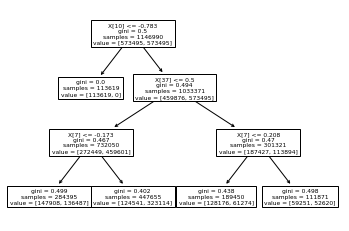

In [70]:
single_forest = tree.DecisionTreeClassifier(max_depth = 3)
tree.plot_tree(single_forest.fit(X_train1, y_train1.values.ravel())) 

Evaluating model performance... 



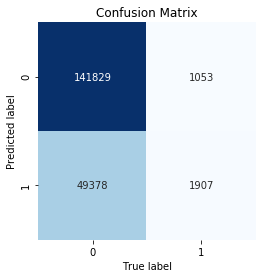

Accuracy: 74.03%
Precision: 3.72%
Recall: 64.43%
F1 Score: 0.1
ROC Area Under Curve: 69.3%


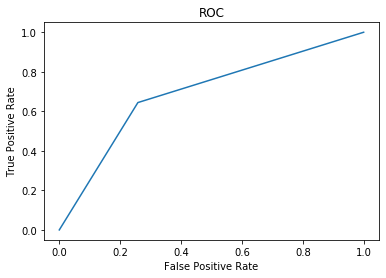

In [71]:
# Cutoff probabilities
y_pred[:,1][y_pred[:,1]>=0.02]=1
y_pred[:,1][y_pred[:,1]<0.02]=0
y_pred1=y_pred[:,1]

#evaluate
model_evaluation(y_pred1, y_test)

The performance of the random forest algorithm is:

1. An AUC of ~70% indicates a high predictive power and the model correctly predicts 70 out of 100 cases.
2. The recall of ~64% indicates that the model manages to correctly identify 64 out of 100 fraud cases.  
4. The accuracy of ~74% indicates that the model correctly predicts 74 out of 100 cases.

In [72]:
forest_features = list(zip(X.columns, forest.feature_importances_))
forest_features.sort(key = lambda x:x[1], reverse=True)

for item in forest_features:
    print(item)

('stdtransactionAmount', 0.19292170392924954)
('stdnumFraud', 0.17921095295443637)
('stdcurrentBalance', 0.1299448966515413)
('stdavailableMoney', 0.12827738357098223)
('stdutilization_rate', 0.12306854403746423)
('stdcreditLimit', 0.052235927828843134)
('posEntryMode_05', 0.03322657546011814)
('stdnumCards', 0.03234807901949449)
('cardPresent', 0.015145204393173685)
('posEntryMode_09', 0.014430734122390671)
('merchantCategoryCode_online_retail', 0.008100161641828961)
('posEntryMode_02', 0.006962696634176331)
('merchantCategoryCode_fastfood', 0.006722625150382298)
('posConditionCode_08', 0.00651971451109621)
('posConditionCode_01', 0.006458380450925424)
('merchantCategoryCode_entertainment', 0.006432710751021615)
('merchantCategoryCode_airline', 0.004517706556103877)
('merchantCategoryCode_online_gifts', 0.004431434782485176)
('merchantCategoryCode_food', 0.004321012561258022)
('merchantCategoryCode_fuel', 0.004229845004248517)
('merchantCategoryCode_subscriptions', 0.00309987322928733

The most important features for the random forest classifier are transaction amount, number of frauds at a merchant level, current balance, available money and utilization rate.

#### Logistic Regression

Logistic Regression is the most common supervised learning algorithm used in binary classification problems. Logistic regression works well with numeric features and generally acts as a good baseline model before trying out different algorithms.

I have used logistic regression with a Stochastic Average Gradient (sag) descent solver which is optimized to work on large datasets. It also incorporates L2 regularization in the model to reduce overfitting.

Evaluating model performance... 



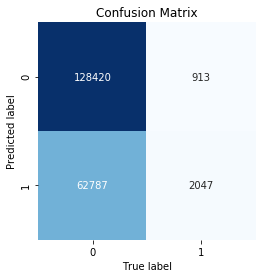

Accuracy: 67.19%
Precision: 3.16%
Recall: 69.16%
F1 Score: 0.1
ROC Area Under Curve: 68.16%


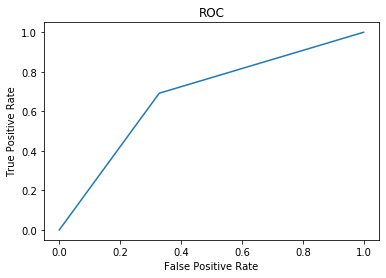

In [75]:
#Logistic Regression
lr = LogisticRegression(solver='sag', penalty='l2', max_iter=500)

#fit
lr.fit(X_train1, y_train1.values.ravel())

#predict
y_pred = lr.predict(X_test)

#evaluate
model_evaluation(y_pred, y_test)

The performance of the logistic regression algorithm is:

An AUC of ~70% indicates a high predictive power and the model correctly predicts 70 out of 100 cases.
The recall of ~70% indicates that the model manages to correctly identify 70 out of 100 fraud cases.
The accuracy of ~67% indicates that the model correctly predicts 67 out of 100 cases.

## References:
    
1. Pandas Official Documentation
https://pandas.pydata.org/docs/

2. Scikit Learn User Guide
https://scikit-learn.org/stable/user_guide.html

3. Seaborn Official tutorial
https://seaborn.pydata.org/tutorial.html

4. Dr. Sebastian Raschka's blog
https://sebastianraschka.com/blog/index.html

5. Dr. Jason Brownlee's blog
https://machinelearningmastery.com/blog/

6. Dr. Leo Breiman's notes on Random Forests
https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm